
# MORDM optimization



###### This codebook consists of the following steps:

###### Step 0: Preparation for running the model
###### Step 1: Generate optimal policies
###### Step 2: Re-evaluate candidate solutions under uncertainty
###### Step 3: Give scores using maximum regret


### Step 0: Preparation for running the model



###### We start with importing some packages, selecting the outputs of the model and running a preliminary model to find the optimal epsilon value and reference scenario


In [1]:
from matplotlib.pyplot import figure
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy, ema_logging, ScalarOutcome

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define the desired problem formulation here

pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [3]:
#A small uncertainty analysis has been ran.
#The goal is to discover the range of values for the outcomes
#This range serves as an input for the Epsilon values

from ema_workbench import Samplers
from ema_workbench import MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000 #These values for n_scenario's and n_policies are high enough to have representative outcomes
n_policies = 100   #But low enough so the model runs in ~2hrs

# If the simulation has already been run and a pickle is already present, that pickle can be used as an input

use_pickle0 = True
if use_pickle0:
    with open('data/MORDM_prep.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies, uncertainty_sampling=Samplers.LHS)
    
    #Save results in Pickle file  
    
    with open('data/MORDM_prep.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)
        
experiments, outcomes = results

In [4]:
# A dictionary which defines the range for every outcome is created

range_outcome= {}
for i in outcomes:
    range_outcome[i]=outcomes[i].max()-outcomes[i].min()

# A list with epsilon values that can be used in the analysis is created
# 1/25 of the range creates epsilon values that generates enough pareto-optimal policies 

list_epsilons = []
for i in range_outcome:
    list_epsilons.append(range_outcome[i]/25)    
    
# Epsilon optimization is necessary, as the number of solutions is very sensitive to this value

In [5]:
# The references values are from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}

# Comparing scenario's with the reference to select scenario's fitted for the problem

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

### Step 1: Generate optimal policies

##### With the epsilon and the reference scenario selected, optimal policies are generated


In [6]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so choose a large number to analyse trends. 

nfe = 75000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 


epsilon = list_epsilons   

convergence_metrics = [EpsilonProgress()]

# The pickle method is used again for potentialy saving (computation) time
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  uncertainty_sampling=Samplers.LHS,
                                                  converge_freq=500,
                                                  logging_freq=500)

# Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU       

    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

##### Epsilon progress is shown

In [7]:
convergence

,epsilon_progress,nfe
0,0,0
1,36,100
2,118,1195
3,151,2293
4,189,3390
...,...,...
66,524,70102
67,524,71179
68,525,72253
69,525,73332


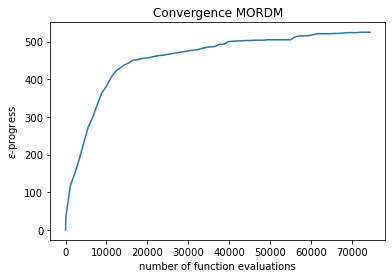

In [8]:
plt.plot(convergence.nfe, convergence.epsilon_progress)

plt.title('Convergence MORDM')
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.savefig(fname="images/MORDM/Convergence.png",dpi=300,bbox_inches='tight',format="png")

plt.show()

##### As can be seen, the simulation has converged well

##### The results are shown below

In [9]:
outcomes = results[list(model.outcomes.keys())] #This makes sure that the outcomes are split from the levers/uncertainties 
outcomes.head()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,1.007149e+08,0.000000,3.740535e+07,0.005162,2.749541e+07,0.007166,0.000000e+00,0.000000,5.092997e+07,0.000000,121200000.0,3991.747365
1,1.124550e+08,0.000000,2.517511e+07,0.028821,6.763015e+07,0.016822,1.106877e+07,0.000000,4.207126e+06,0.004633,151900000.0,0.000000
2,9.080813e+07,0.002009,2.517511e+07,0.028821,7.701177e+07,0.000000,3.899395e+06,0.002368,4.207126e+06,0.004633,151900000.0,0.000000
3,1.416787e+08,0.000241,3.142483e+07,0.004318,5.623211e+07,0.000000,2.113239e+07,0.000435,2.757823e+07,0.000000,30700000.0,2673.207864
4,1.061746e+08,0.021042,2.562019e+07,0.010527,3.277129e+07,0.009814,1.106877e+07,0.000000,5.346847e+07,0.001018,30700000.0,1759.815805


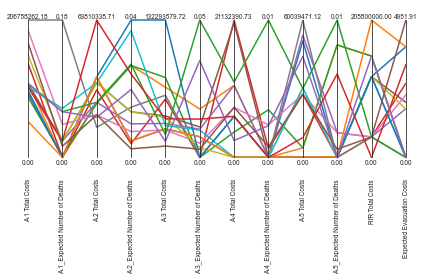

In [10]:
from ema_workbench.analysis import parcoords

# Making a pairplot

limits = parcoords.get_limits(outcomes)
limits.loc[0, outcomes.keys()] = 0

axes = parcoords.ParallelAxes(limits, fontsize=6.5, rot=90)
axes.plot(outcomes)
plt.savefig(fname="images/MORDM/parallel_axes.png",dpi=300,bbox_inches='tight',format="png") # Save to file

plt.show()

### Step 2: Re-evaluate candidate solutions under uncertainty

##### The criteria are defined and the policies are selected based on said criteria, which cuts down on their number

In [11]:
A3_deaths_per_year = 0.001      # Translates roughly 1 in 100:000 yearly chance of dike breakage in A.3 ring
other_deaths_per_year = 0.025   # Translates roughly 1 in  10:000 yearly chance of dike breakage in other dike rings
max_A3_total_costs = 170000000  # Our max preferred costs
max_rfr_costs = 1950000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation

In [12]:
print(list(outcomes.keys()))

['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']


In [13]:
criteria_dict = {}
if pf == 3:
    
    # Sum the deaths for all other dike rings
    results["Expected Number of other Deaths"] = results[[f'A.{dike_ring}_Expected Number of Deaths' for dike_ring in [1, 2, 4, 5]]].sum(axis=1)
    
    # Define the citerea
    criteria_dict['A.3_Expected Number of Deaths'] = A3_deaths_per_year
    criteria_dict['A.3 Total Costs'] = max_A3_total_costs
    criteria_dict['RfR Total Costs'] = max_rfr_costs
#    criteria_dict['Expected Number of other Deaths'] = other_deaths_per_year
    
else:
    print(f"TODO: Implement these criteria for problem formulation {pf}")

In [14]:
# Filter results DataFrame for criteria
logical = None
policies = results

print(f"Number of logical policies: {len(policies.index)}")
for column, value in criteria_dict.items():
    logical = policies[column] <= value
    print(f"Number of logical policies: {len(policies.index)} (after filtering {column} <= {value})")
    policies = policies[logical]

print(f"Number of logical policies: {len(policies.index)}")

Number of logical policies: 16
Number of logical policies: 16 (after filtering A.3_Expected Number of Deaths <= 0.001)
Number of logical policies: 4 (after filtering A.3 Total Costs <= 170000000)
Number of logical policies: 4 (after filtering RfR Total Costs <= 1950000000)
Number of logical policies: 4


In [15]:
policies.shape

(4, 44)

In [16]:
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop('Expected Number of other Deaths', axis=1)
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2,0,0,0,0,0,0,0,1,0,0,...,0,6,0,8,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,6,1,0,0,1,3,2,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,7,1,0,1,0,0,2,0,3
10,0,0,0,0,0,0,0,0,0,0,...,0,7,7,7,0,0,1,0,0,0


In [17]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

##### The selected policies are once again plugged into the model in order to see how they perform when subjected to a wide range of different scenarios, which will enable us to perform a robustness analysis

In [18]:
# The pickle method is once again used
use_pickle2 = False
if use_pickle2:
    with open(f"data/MORDM_results2_pf{pf}.pickle","rb") as filehandler:
        results2 = pickle.load(filehandler)

else:
    # Pass the policies list to EMA workbench experiment runs
    n_scenarios = 250
    with MultiprocessingEvaluator(model) as evaluator:
        results2 = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)
    # Save results in Pickle file
    with open(f"data/MORDM_results2_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(results2,filehandler)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 250 scenarios * 4 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


##### After running the model, robustness is performed. This is done by first looking at the standard deviation, which means that the performance of the policy over the many different scenarios is checked for consistency of said performance

In [19]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [20]:
experiments2, outcomes2 = results2

overall_scores = {}
for policy in np.unique(experiments2['policy']):
    scores = {}
    
    logical = experiments2['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes2[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
10,8.234228e+16,0.019346,4.906028e+16,0.035505,5.921830e+15,0.000221,9.049944e+14,0.000136,9.647409e+15,0.006689,0.0,0.000000e+00
2,1.610223e+17,0.051795,3.232263e+16,0.022679,5.526335e+15,0.000784,8.136094e+14,0.000165,9.765043e+15,0.006730,0.0,0.000000e+00
3,3.605940e+17,0.001653,3.592869e+16,0.000369,4.787855e+15,0.000012,1.016532e+15,0.000002,1.051753e+16,0.000067,0.0,2.807621e+08
7,1.355364e+18,0.617378,2.782316e+16,0.018983,2.158450e+15,0.000147,7.001736e+14,0.000104,7.969692e+15,0.001584,0.0,0.000000e+00


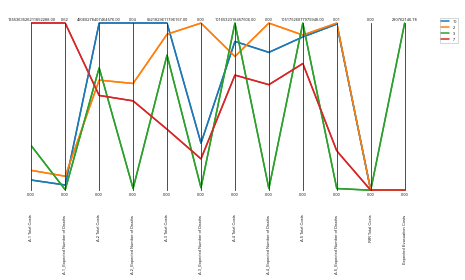

In [21]:
colors = sns.color_palette()

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=4)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
paraxes.plot(data)
plt.savefig(fname="images/MORDM/robust_parallel_axes.png",dpi=300,bbox_inches='tight',format="png") # Save to file

plt.show()

### Step 3: Give scores using maximum regret

##### After looking at the signal-to-noise ratio, maximum regret is looked into to see how the policies compare the the best policy for a given scenario

In [22]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [23]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\Mateo\AppData\Local\Temp\ipykernel_15028\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_15028\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_15028\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_15028\72777

##### The figure below shows the normalized maximum regret per policy. Here, a higher score means more regret, with a maximum of 1.

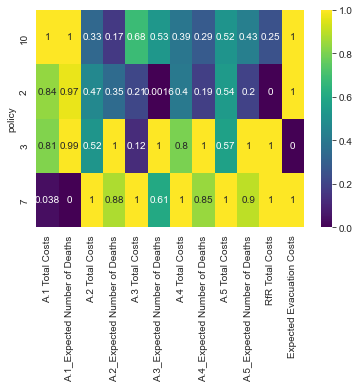

In [24]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig(fname="images/MORDM/robust_maxregret_parallel_axes.png",dpi=300,bbox_inches='tight',format="png") # Save to file
plt.show()

##### The figure below shows the non-normalized maximum regret per policy. A higher score means more regret.


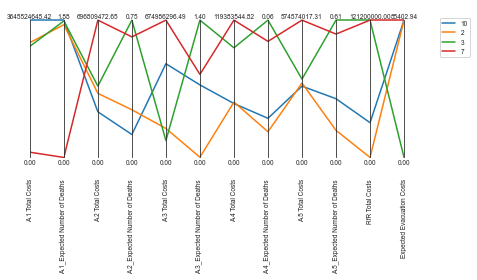

In [25]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize = 6.5)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.savefig(fname="images/MORDM/robust_maxregret_parallel_axes.png",dpi=300,bbox_inches='tight',format="png") # Save to file 

plt.show()

In [26]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

##### The figure below shows the bar plot of the regret. It gives us a better understanding of the distribution of regret.

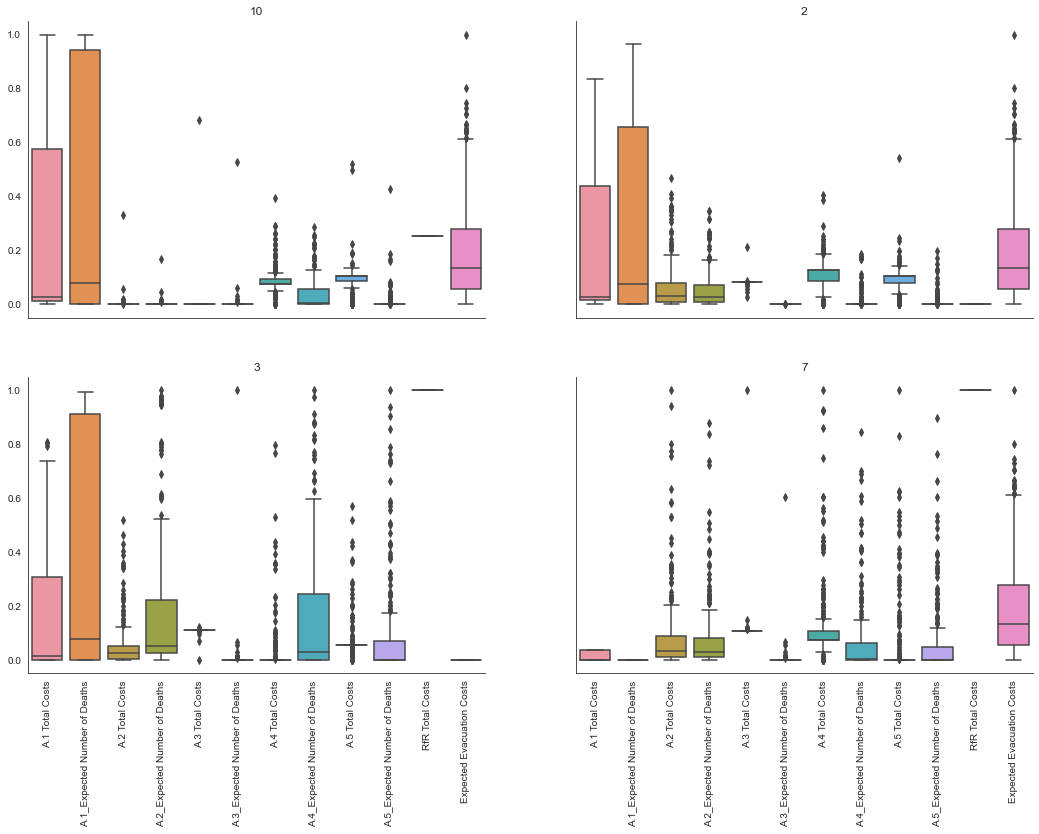

In [27]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18,12), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0], axes[1,1]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    # Rotate x-axis labels slightly to make them redable
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig(fname="images/MORDM/robust_boxplot.png",dpi=300,bbox_inches='tight',format="png")
       
plt.show()